# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [0]:
#%tensorflow_version 2.x

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [18]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo
print(skvideo.__file__)
import skvideo.io

d:\anaconda3\envs\cnn\lib\site-packages\skvideo\__init__.py


## Подготовка датасета для классификации

In [15]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

data_list = []
data_root = 'G:/data/KTH/'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        data_list.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [0]:
SUBSET_LEN = 400 # Количество пар для обучения
MAX_FRAMES = 600
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001

In [0]:
class CreatingDataset():

  """Клас создания датасета"""

  def __init__(self,data_list=data_list, MAX_FRAMES=MAX_FRAMES, SUBSET_LEN=SUBSET_LEN, BATCH_SIZE=BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS):        
      self.data_list = data_list 
      self.MAX_FRAMES = MAX_FRAMES
      self.SUBSET_LEN = SUBSET_LEN
      self.BATCH_SIZE = BATCH_SIZE
      self.NUM_EPOCHS = NUM_EPOCHS

  def split_dataset(self, data_list, SUBSET_LEN):
    """Создание пар для обучения и разделение датасета на тестовый и тренировачный"""
    random.shuffle(data_list)
    data_array = np.array(data_list)
    train_x, valid_x, train_y, valid_y = train_test_split(data_array[:, 0],
                                                          data_array[:, 1],
                                                          train_size=SUBSET_LEN, random_state=21,
                                                          stratify=data_array[:, 1])

    assert SUBSET_LEN == len(train_x)

    dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    test_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

    return dataset, test_dataset

  def dataset_processing(self, dataset, SUBSET_LEN, BATCH_SIZE):
    """обработка датасета"""



    def fpath_to_video(fpath):
        fpath = fpath.numpy().decode('utf-8')
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.

        tmp = videodata.copy()
        # если количество кадров в видео меньше максимального
        if videodata.shape[0] < MAX_FRAMES:
          # то определяем сколко раз надо повторить операцию vstack
          num_iter = round(MAX_FRAMES / videodata.shape[0]) + 1
          # создаем временный файл, в котором будем хранить повторы
          tmp = videodata.copy()
          # стакаем необходимое количество раз
          for iterations in range(num_iter):
            tmp = np.vstack((tmp, videodata))
            if tmp.shape[0] > MAX_FRAMES:
              break
          # так как мы повторяли ролик сам в себя несколько раз, то его длина может быть больше чем необходимая
          # поэтому возьмем только необходимое нам количество кадров
        tmp = tmp[:MAX_FRAMES, ...]
        
        return tmp

    dataset = dataset.map(lambda fpath, label: (tf.py_function(fpath_to_video, [fpath], Tout=tf.float32),
                                                tf.numpy_function(np.int8, [label], tf.int8)))
    # dataset = dataset.shuffle(buffer_size=SUBSET_LEN)
    # dataset = dataset.batch(BATCH_SIZE)

    return dataset

  def bilder_dataset(self,data_list=data_list, MAX_FRAMES=MAX_FRAMES, SUBSET_LEN=SUBSET_LEN, BATCH_SIZE=BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS):
    """Сборка доатасета"""
    dataset, test_dataset = self.split_dataset(data_list, SUBSET_LEN)
    dataset = self.dataset_processing(dataset, SUBSET_LEN, BATCH_SIZE)
    test_dataset = self.dataset_processing(test_dataset, SUBSET_LEN, BATCH_SIZE)

    return dataset, test_dataset



In [0]:
CD = CreatingDataset()
dataset, test_dataset = CD.bilder_dataset(data_list, MAX_FRAMES, SUBSET_LEN, BATCH_SIZE, NUM_EPOCHS)

In [20]:
train_np = np.stack(list(dataset))
test_np = np.stack(list(test_dataset))
print(type(train_np), train_np.shape)
print(type(test_np), test_np.shape)

UnknownError: ignored

## Визуализация кадра из видео

## Визуализация "движения"

## Создание модели CNN

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

## Подготовка к обучению

In [0]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

## Цикл обучения модели

In [11]:
%%time
global_step = 0
losses = []
for ep in range(NUM_EPOCHS):
    for i, (videodata, labels) in enumerate(dataset):
        loss_value = model.train_on_batch(videodata, labels)

        if i % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{i}/{SUBSET_LEN}] Loss: {loss_value}')
            losses.append([loss_value, global_step])
               
        global_step += 1

UnknownError: ignored

## TensorBoard

In [0]:
%load_ext tensorboard
%tensorboard --logdir logs

## Тестирование обученной модели

True class: boxing
Predicted class: boxing


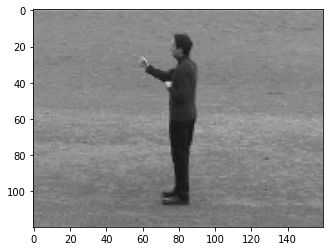

In [0]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])